## This automated portfolio system uses an existing model for stock returns; the price momentum alpha generator.
## An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
## I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


## The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [4]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed

3 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['BRK.B', '-']: Exception('%ticker%: No data found, symbol may be delisted')


In [5]:
sp500.tail(1) #Adjusted Close

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-23,132.029999,15.13,182.520004,178.089996,152.660004,119.459999,87.290001,377.320007,553.440002,190.110001,...,104.160004,59.330002,103.839996,33.91,125.629997,138.320007,129.179993,274.98999,39.029999,197.210007


In [6]:
# Define the time period and lag, can be changed to any number and code will work
time_period = 1260  # 5 years
lag = 20 # lag of 20 days


## Momentum Factors:
 ### Parameter for calculation is used for the backtest. The backtest will run 5 years but can be changed as long as there is sufficient data downloaded.

In [7]:
#how_many_days_back = 0 for current, 1260 for 5 years. It's for backtesting.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [8]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.050100,38.096976,6.457858,0.129240,1.032730e+05
AAL,-0.015422,44.558577,-7.021289,-0.047606,9.201756e+07
AAPL,0.125285,58.140992,14.770451,0.308407,3.098047e+07
ABBV,0.081385,39.348342,10.077664,0.182460,-9.235148e+05
ABNB,NaN,35.255589,-4.840039,-0.033525,1.563145e+06
...,...,...,...,...,...
YUM,0.030187,36.218730,3.422365,0.069088,4.719718e+04
ZBH,0.004801,33.341035,-0.447945,0.027000,-9.237770e+04
ZBRA,0.060679,55.890687,3.322522,0.131867,-1.372618e+05


In [9]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [10]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    41.969754
MRNA    19.532002
NVDA    17.701225
ENPH    15.938234
NVR     15.256176
BLDR     9.885528
CMG      9.620581
AZO      9.397933
AMD      9.227651
FCX      8.321786
dtype: float64

Short Basket:
Ticker
BXP    -5.110952
VZ     -5.110987
PARA   -5.277546
WBA    -5.433867
ILMN   -5.530284
WBD    -5.955983
VTRS   -5.964378
BAX    -6.188899
FIS    -6.323549
VFC    -7.852546
dtype: float64


## Creating the Back-Tested Baskets

In [11]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.914618
NVDA    17.199018
AMD     15.881548
CZR     13.391847
ETSY    13.303957
NFLX    12.356357
ALGN    11.322830
PAYC    11.073673
ENPH     8.180840
TTWO     8.156892
dtype: float64
Short Basket Past 5 Years:
Ticker
BBWI   -5.004655
F      -5.014237
BEN    -5.186709
HWM    -5.240769
APA    -5.494870
CMG    -5.557403
MCK    -5.559288
SLB    -5.668554
EQT    -6.506751
GE     -6.717279
dtype: float64


## Cumulative Returns

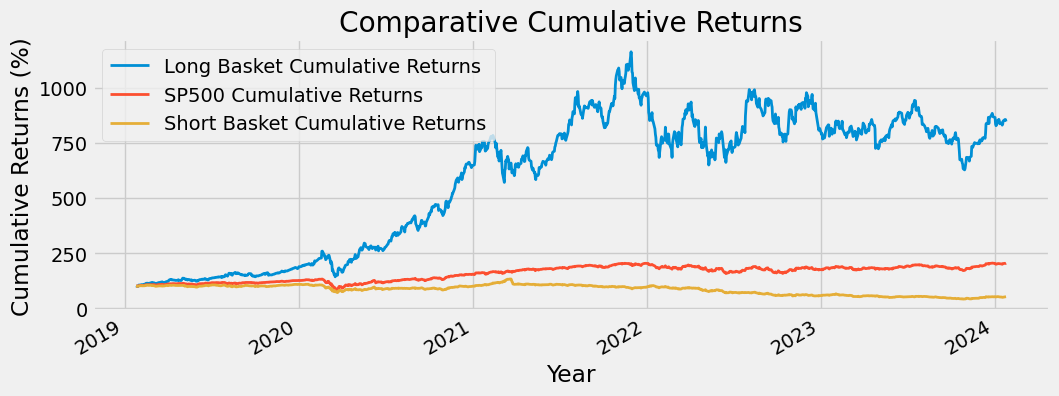

In [12]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# Back Tested Cumulative Returns

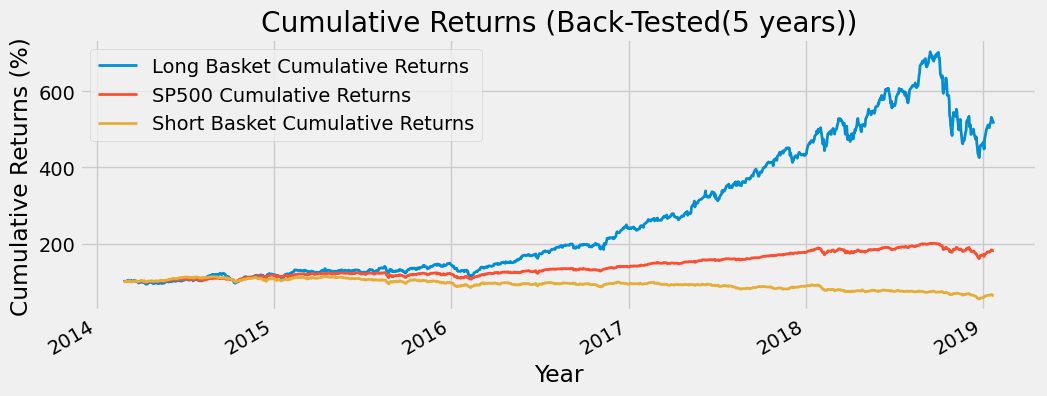

In [25]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested(5 years))')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# As of most current day:

In [13]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
847.2701170737807
Short Basket Cumulative Returns: Most current day
52.68518047871956
SP500 Cumulative Returns: Most current day
204.81216497062053


In [14]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-02-24 Long Basket has outperformed the SP500 by 642.4579521031602 percentage points
As of 2024-02-24 Short Basket has underperformed the SP500 by -152.12698449190097 percentage points


## Monthly Potfolio Returns

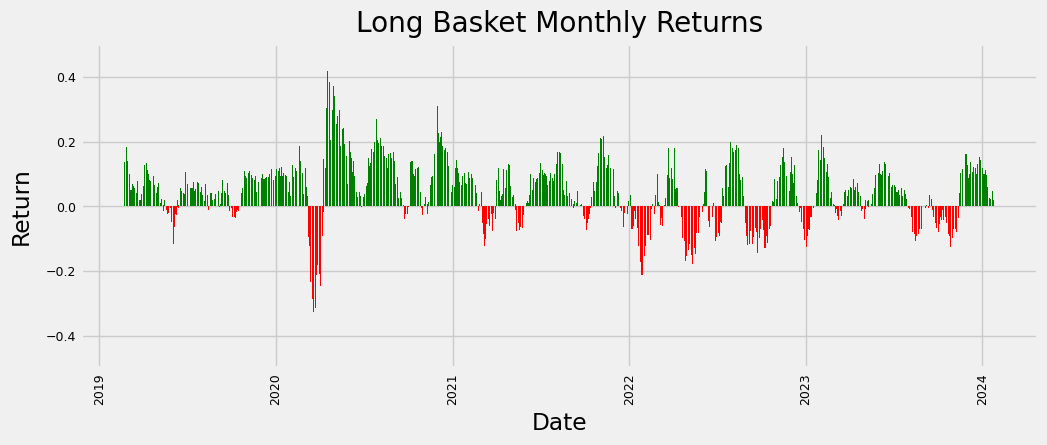

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

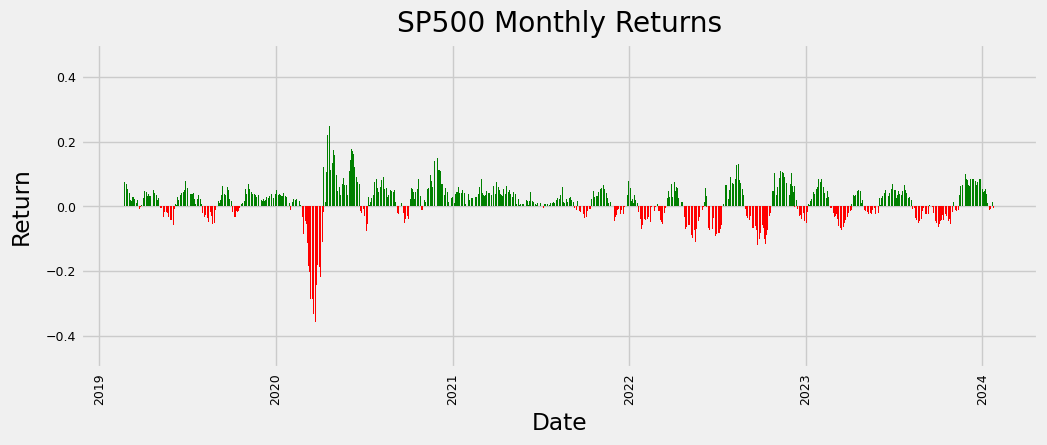

In [17]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

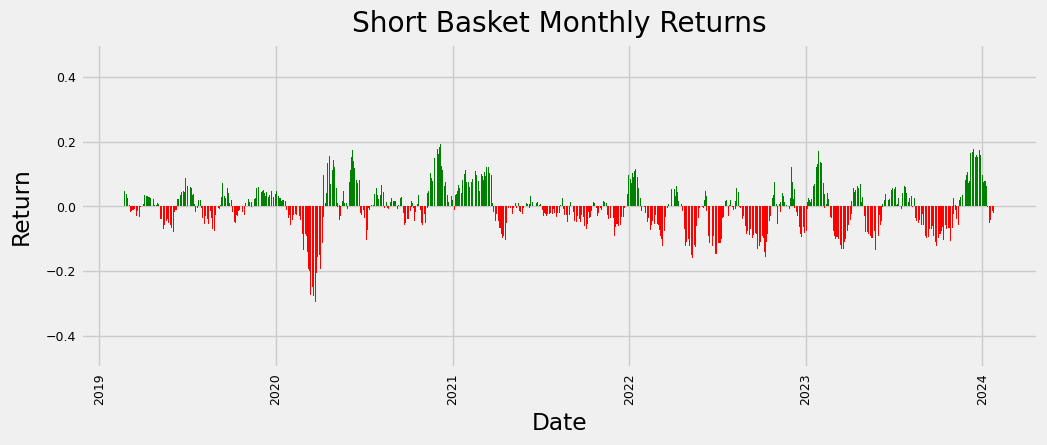

In [18]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Monthly return for long picks vs short picks vs SP500

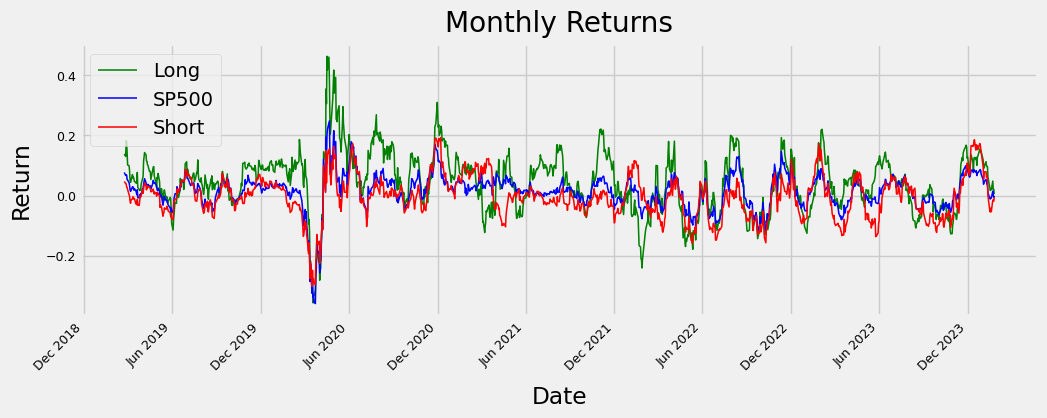

In [24]:
# Three plots 
plt.style.use('fivethirtyeight')
long_monthly_returns.plot(figsize=(11,4), label = 'Long', color = 'g', lw=1.1)
monthly_returns.plot(figsize=(11,4), label = 'SP500', color ='b', lw = 1.1)
short_monthly_returns.plot(figsize=(11,4),label= 'Short', color = 'r', lw=1.1)

# Plot configurations 
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y',))
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=9)
plt.ylabel('Return',labelpad=9)
plt.xlabel('Date',labelpad=9)
plt.title('Monthly Returns',pad=9)
plt.show()

# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [20]:
%%capture 
import os
import sys
# ^ this is used to suppress the output of the cell

# Getting the directory for the module were going to import
current_dir = os.getcwd()[:-17] #removing the last 17 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

In [21]:
ef = EfficientFrontier(sp500[long_basket.index])
ef.calculate_portfolio() #Printing Annual Returns

Ticker
TSLA    1.408733
MRNA    1.584671
NVDA    1.621588
ENPH    1.597100
NVR     1.233638
BLDR    1.439825
CMG     1.213852
AZO     1.193769
AMD     1.548201
FCX     1.173828
dtype: float64


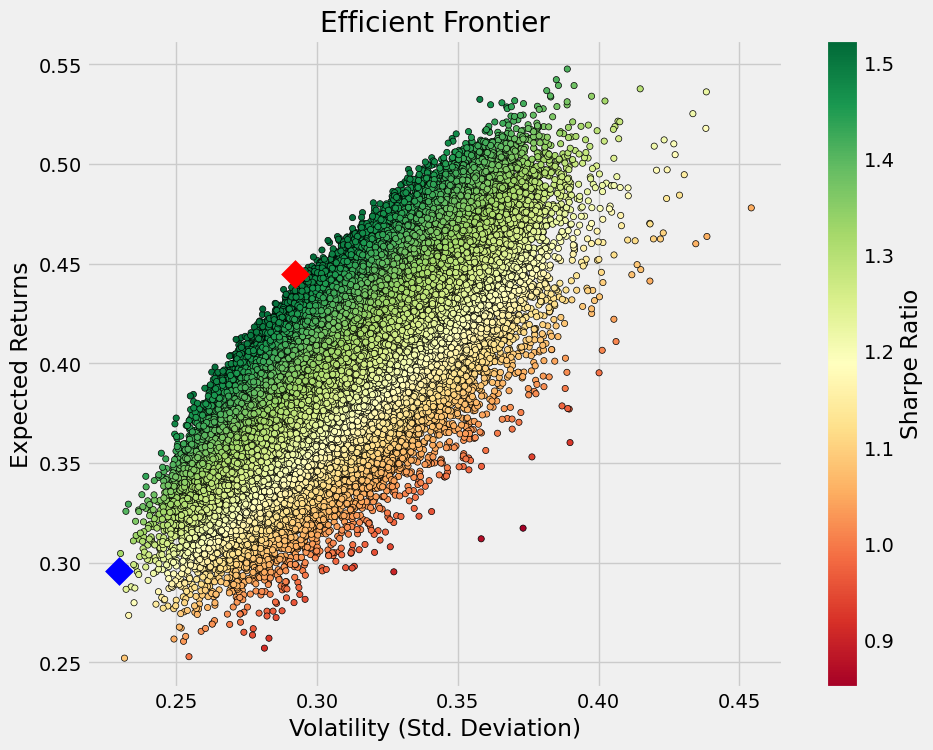

In [22]:
ef.plot_frontier()

In [23]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.295783                  0.444951
Volatility                        0.229461                  0.291987
Sharpe Ratio                      1.289036                  1.523871
TSLA Weight                       0.003314                  0.004864
MRNA Weight                       0.112095                  0.139973
NVDA Weight                       0.093934                  0.244086
ENPH Weight                       0.000712                  0.040736
NVR Weight                        0.329809                  0.031741
BLDR Weight                       0.005461                  0.135134
CMG Weight                        0.058285                  0.071386
AZO Weight                        0.300035                  0.209264
AMD Weight                        0.008729                  0.109689
FCX Weight                        0.087626                  0.013126
